#### Imports

In [1]:
import logging

# Data Processing
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Matlab file parsing
from scipy.io import loadmat

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

### Neural Networks

#### Neural Network Architecture
- Input layer: 400 (20*20) + bias = 401 nodes
- Hidden layer (1): 25 + bias = 26 nodes
- Output layer: 10 (onehot encoded) nodes

#### Import the MNIST dataset

In [3]:
''' The data is comprised of:
 X - 5000 examples of 20*20 grayscaled (luminosity)
     Shape (5000, (20*20)) : (5000, 400)
 Y - 5000 labels {0: 10, 1:1, 2:2 , ....} there is no zero-index.
     Shape (5000, 1)
'''
data = loadmat("data/ex4data1")

X: np.ndarray = np.c_[np.ones((data['X'].shape[0], 1)), data['X']]
y: np.ndarray = OneHotEncoder(handle_unknown='ignore').fit_transform(data['y']).toarray()

# [hiddenLayer, outputLayer] Shape: (25*401, 26*10)
annWeights = loadmat("data/ex4weights.mat")

print(data.keys())
print("Training set data: ", X[:, 1:].shape)
print("Label set data: {} ". format(y.shape))
print("Training data with intercept: ", X.shape)

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Training set data:  (5000, 400)
Label set data: (5000, 10) 
Training data with intercept:  (5000, 401)


#### Visualising the data

In [142]:
def plotMNISTSample(data_set: np.ndarray, sample_number: int = 10, row_number: int = 10, column_number: int = 10) -> None:
    '''
    Plots a given number of MNIST dataset samples in a (10, -1) shape.
    @arg data_set (np.ndarray) - The target dataset in a (image_number, pixel_count) shape.
    @arg sample_number (int) - The number of samples to plot.
    @arg row_number (int) - The number of rows in the plot.
    @arg column_number (int) - The number of columns in the plot.
    '''
    
    sampleDataIndeces = np.random.choice(data_set.shape[0], sample_number) if sample_number != 0 else np.arange(data_set.shape[0])

    # Plot the selected features
    figure, axes = plt.subplots(row_number, 1, figsize=(15,5))
    [ax.set_axis_off() for ax in axes.ravel()]

    for i in range(column_number, (sampleDataIndeces.shape[0] +1), column_number):
        axes[(int(i/row_number) -1)].imshow(data_set[sampleDataIndeces[max(i-column_number, 0):i], 1:].reshape(-1, 20).T)

    plt.subplots_adjust(wspace=0, hspace=0)

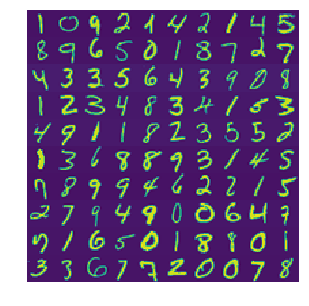

In [143]:
plotMNISTSample(X, 100)

### Feedforward and cost function

\begin{align}
g'(z)= \frac{\partial}{\partial{z}}=g(z)(1-g(z))
\end{align}
where
\begin{align}
g(z)=\frac{1}{1+e^{-z}}
\end{align}

In [6]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    '''
    Performs an element-wise sigmoidal transformation on the given argument.
    @arg z (np.ndarray) - The target variable to be transformed
    @return (copy) - A copy of the transformed variable
    '''
    return (1 / (1 + np.exp(-z)))

def sigmoidGradient(z: np.ndarray) -> np.ndarray:
    return sigmoid(z)*(sigmoid(1-z))

#### Cost Function
\begin{align}
J(\theta)=\frac{1}{m}\sum^{m}_{t=1}\sum^{k}_{k=1}\big[-y_{k}log((h_{\theta}(x^{(i)}))_{k})-(1-y^{(i)}_{k})log(1-(h_{\theta}(x^{(i)}))_ {k})\big]
\end{align}

#### Regularized Cost Function
\begin{align}
J(\theta)=\frac{1}{m}\sum^{m}_{t=1}\sum^{k}_{k=1}\bigg[-y_{k}log((h_{\theta}(x^{(i)}))_{k})-(1-y^{(i)}_{k})log(1-(h_{\theta}(x^{(i)}))_ {k})\bigg] 
+ \frac{\lambda}{2m}\bigg[\sum^{725}_{j=1}\sum^{400}_{k=1}(\Theta^{(i)}_ {j,k})^{2}+\sum^{10}_ {j=1}\sum^{25}_{k=11}(\Theta^{(2)}_{j,k})^{2}\bigg]
\end{align}

In [16]:
def annCostFunction(theta: np.ndarray, features: np.ndarray, predictor: np.ndarray, regCoeff: float) -> np.ndarray:
    theta1, theta2 = theta['Theta1'], theta['Theta2']
    
    # Forward Propagation #
    
    m = features.shape[0]
    
    # (5000, 401)
    a1 = features
    # (25, 401) * (401, 5000) = (25, 5000)
    z2 = theta1.dot(a1.T)
    # (5000, 26)
    a2 = np.c_[np.ones((m ,1)),sigmoid(z2).T]
    
    #output layer
    a3 = sigmoid(theta2.dot(a2.T))
    
    # expected cost with Theta1 and Theta2 is 0.287629
    J = -1 * (1/m) * np.sum(np.log(a3.T)*predictor + np.log(1-a3).T*(1-predictor)) + \
    (regCoeff/(2*m))*(np.sum(np.square(theta1[:, 1:]))+np.sum(np.square(theta2[:,1:])))
    
    # Backpropagation #
    d3 = a3.T - predictor
    # (25, 10).T * (10, 5000) * (25, 5000) = (25, 5000)
    d2 = theta2[:, 1:].T.dot(d3.T)*sigmoidGradient(z2)

    # (25, 5000) * (5000, 401) = (25, 401)
    delta1 = d2.dot(a1) 
    # (10, 5000)* (5000, 26) = (10, 26) 
    delta2 = d3.T.dot(a2)
    
    grad1 = delta1 / m + np.c_[np.zeros((delta1.shape[0], 1)), delta1[:,1:]]
    grad2 = delta2 / m + np.c_[np.zeros((delta2.shape[0], 1)), delta2[:,1:]]
    
    return (J, grad1, grad2)

In [17]:
%%time

print((annCostFunction(annWeights, X, y, 1)[0]))

0.38376985909092365
Wall time: 48 ms


### Gradient Validation

In [18]:
from typing import Callable

def validateGrad(target: float, theta : np.ndarray, epsilon: float, costFunc: Callable[[], np.ndarray]) -> bool:
    '''
    Computes the two-sided approximate gradient value for the provided arguments.
    Its purpose is to validate an aNN's backpropagation gradient value.
    Should only be run initially to validate the gradients, O(n^2) function
    @arg target (float) - The computed gradient through the backpropagation algorithm
    @arg theta (np.ndarray)
    @arg epsilon (float)
    @arg costFunc (Callable[[], np.ndarray]) - The cost function to approximate the gradient with.
    @return (bool) - True if the gradient is valid.
    '''
    if(not callable(costFunc)):
        logging.error('validateGrad: arg costFunc invalid type. Expected type: function, provided type:', type(costFunc))
        return
    
    if(epsilon > 1e-4):
        logging.warning('validateGrad: Small values of epsilon are preferred in order to guarantee a sound gradient approximation.')
    
    # Approximate J(theta) in this ugly function
    for i in gradient.size:
        theta[i] += epsilon
        approxGradientLambda += costFunc(theta + epsilon)
        theta[i] -= 2 * epsilon
        approxGradientLambda -= costFunc(theta + epsilon)                        
        approxGradientLambda /= (2*epsilon)
        theta[i] += epsilon
                                 
    return (approxGradientLambda - target < 1e-7)

### Visualising the Hidden layer

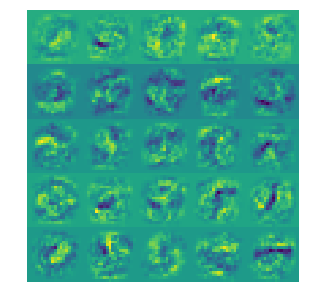

In [144]:
#Retrieve the first layer's weights keeping the Bias unit
first_layer= annWeights['Theta1']

plotMNISTSample(first_layer, 0, 5, 5)